## Importing necessary libraries.

In [1]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PMLS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading dataset.

In [3]:
df = pd.read_csv('email.csv')
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


## Data cleaning

In [4]:
df['label'].value_counts()

label
ham               4825
spam               747
{"mode":"full"       1
Name: count, dtype: int64

In [5]:
print(df['label'].unique())

['ham' 'spam' '{"mode":"full"']


In [6]:
df = df[df['label'].isin(['ham', 'spam'])]
print(df['label'].unique())

['ham' 'spam']


In [7]:
df.isna().sum()

label    0
text     0
dtype: int64

In [8]:
df.dropna(inplace=True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_14224\1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [9]:
df.isna().sum()

label    0
text     0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(415)

In [11]:
df.drop_duplicates(inplace=True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_14224\3006716147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5157 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5157 non-null   object
 1   text    5157 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


## Preprocessing the dataset.

In [15]:
def preProcess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s', ' ', text)

    # Tokenize and remove stopwords
    tokens = text.lower().split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    #stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

if 'text' in df.columns:
    df['text'] = df['text'].astype(str)
else:
    raise ValueError("The 'text' column does not exist in the dataframe.")
#applying preprocessing

df['text'] = df['text'].apply(preProcess_text)

#display data
df.head()
    

C:\Users\PMLS\AppData\Local\Temp\ipykernel_14224\4214966338.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str)
C:\Users\PMLS\AppData\Local\Temp\ipykernel_14224\4214966338.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(preProcess_text)


,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah think goe usf live around though


## Feature selection

In [16]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text']).toarray()

k = 1000
selector = SelectKBest(chi2, k=k)
X_new = selector.fit_transform(X, df['label'])
y = df['label']

## Apply spam filter algorithms , training models and making predictions

In [17]:
#splitting dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.3, random_state=42)

#initialize models
nb_model = GaussianNB()
nb_multinomial_model = MultinomialNB()
j48_model = DecisionTreeClassifier()


#training models
nb_model.fit(X_train, y_train)
nb_multinomial_model.fit(X_train,y_train)
j48_model.fit(X_train,y_train)

#predict models
y_pred_nb = nb_model.predict(X_test)
y_pred_nb_multinomial = nb_multinomial_model.predict(X_test)
y_pred_j48 = j48_model.predict(X_test)

#evaluate accuracy
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_multinomial_accuracy = accuracy_score(y_test, y_pred_nb_multinomial)
j48_accuracy = accuracy_score(y_test, y_pred_j48)

print(f'Naive Bayes Accuracy: {nb_accuracy}')
print(f'Multinomial Naive Bayes Accuracy: {nb_multinomial_accuracy}')
print(f'J48 Accuracy: {j48_accuracy}')

Naive Bayes Accuracy: 0.9760981912144703
Multinomial Naive Bayes Accuracy: 0.9832041343669251
J48 Accuracy: 0.9689922480620154


## Printing Confusion Matrix

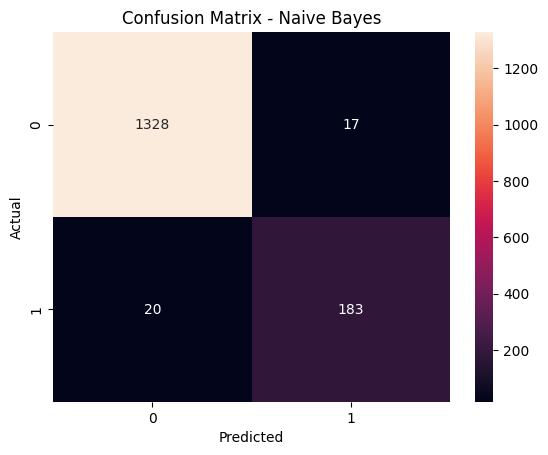

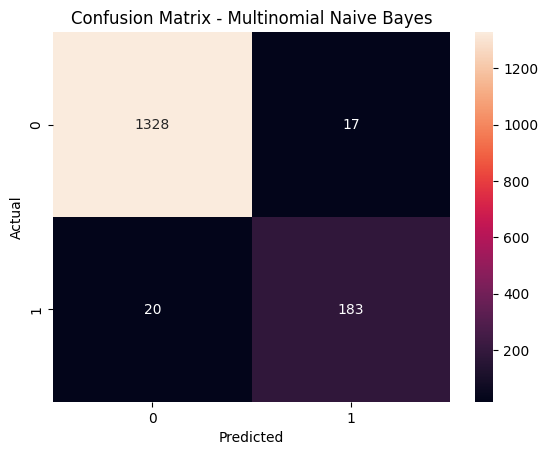

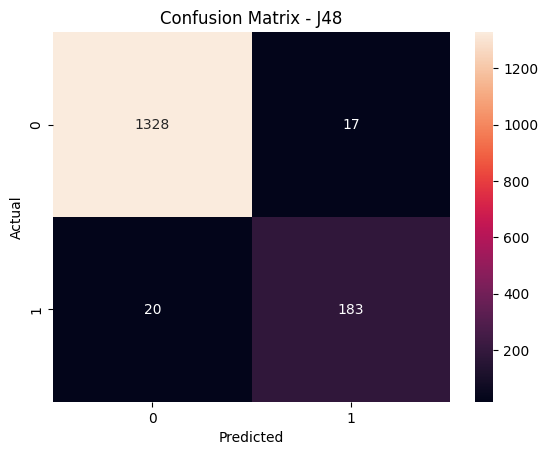

In [18]:
#confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix for Multinomial Naive Bayes
cm_nb_multinomial = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb_multinomial, annot=True, fmt='d')
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#confusion matrix for J48
cm_j48 = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_j48, annot=True, fmt='d')
plt.title('Confusion Matrix - J48')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Comparing Accuracies

In [19]:
print(f'Naive Bayes Accuracy: {nb_accuracy}')
print(f'Multinomial Naive Bayes Accuracy: {nb_multinomial_accuracy}')
print(f'J48 Accuracy: {j48_accuracy}')

Naive Bayes Accuracy: 0.9760981912144703
Multinomial Naive Bayes Accuracy: 0.9832041343669251
J48 Accuracy: 0.9689922480620154


## Prediction function

In [37]:
def predict_email(model, email_text):
    preprocessed_email = preProcess_text(email_text)
    email_vector = vectorizer.transform([preprocessed_email]).toarray()
    selected_email = selector.transform(email_vector)
    prediction = model.predict(selected_email)[0]
    return prediction

#input your own email text or uncomment any of the below....

#email_text = df['text'].iloc[10]
#email_text = "Welcome to the Specialization! You’ve just joined Machine Learning Specialization. Congratulations—you’ve taken a huge step by committing to mastering a skill. We’re excited for you!Before you dive in, we have a few tips to help you succeed:1. Start with the first course. There are 3 courses and a Capstone Project in this Specialization. The first course is Supervised Machine Learning: Regression and Classification . It's available to start today. 2. Set a schedule and mark your calendar. There’s a lot of material to learn, and our most successful learners tell us they’re diligent about setting a schedule and sticking to it. In most Specializations you should plan to complete one course every 4-6 weeks.3. Find a study group. Learners are much more likely to successfully complete a course if they enroll with friends, or connect with other learners in the course forums.Now that you have some solid learning tips under your belt, it’s time to jump into Machine Learning!"

nb_prediction = predict_email(nb_model, email_text)
print(f'Naive Bayes Prediction: {nb_prediction}')

nb_multinomial_prediction = predict_email(nb_multinomial_model, email_text)
print(f'Muiltinomial Naive Bayes Prediction: {nb_multinomial_prediction}')

j48_prediction = predict_email(j48_model, email_text)
print(f'J48 Prediction: {j48_prediction}')



Naive Bayes Prediction: ham
Muiltinomial Naive Bayes Prediction: ham
J48 Prediction: ham
